# Imports

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load Data

In [2]:
image_size = (224, 224)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/trashnet-resized/compostnet-dataset-resized/compostnet-dataset-resized",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 2574 files belonging to 6 classes.
Using 2060 files for training.
Using 514 files for validation.


In [3]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Visualise Data

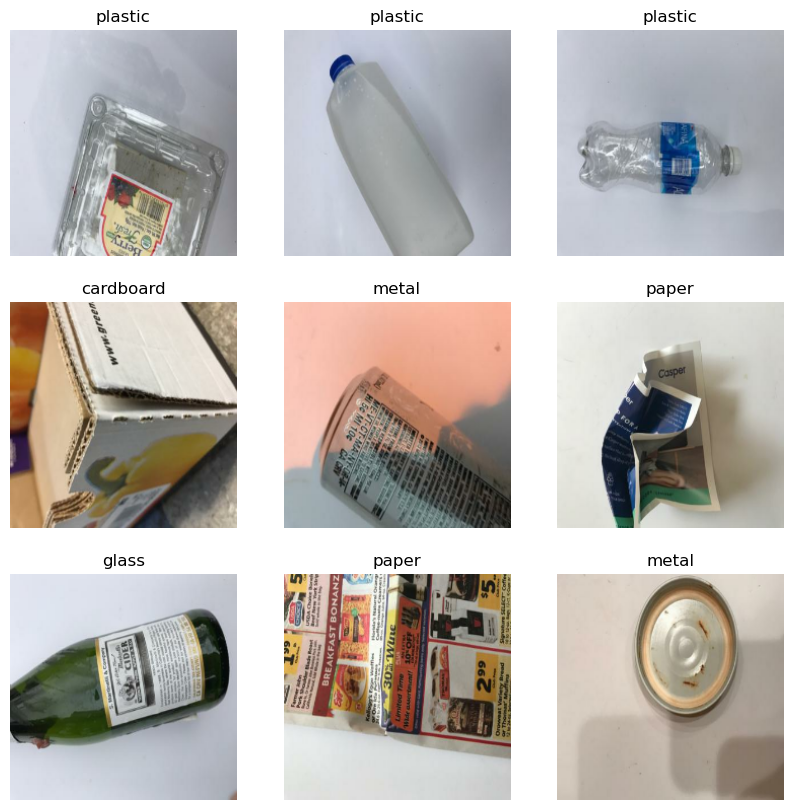

In [4]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(int(labels[i]))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation

In [5]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

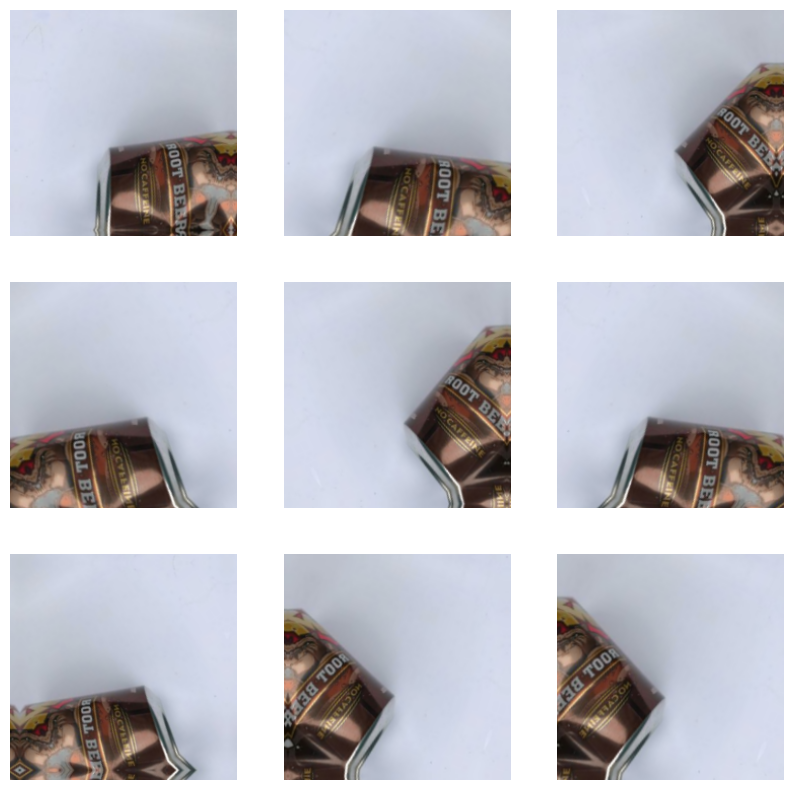

In [6]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Configure Dataset for Performance

In [7]:
# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build Model

### Layers

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(scale=1./255)(x)
x = base_model(x, training=False)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


9406464/9406464 [==============================] - 0s 0us/step


### Model Summary

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                      

### Plot Model

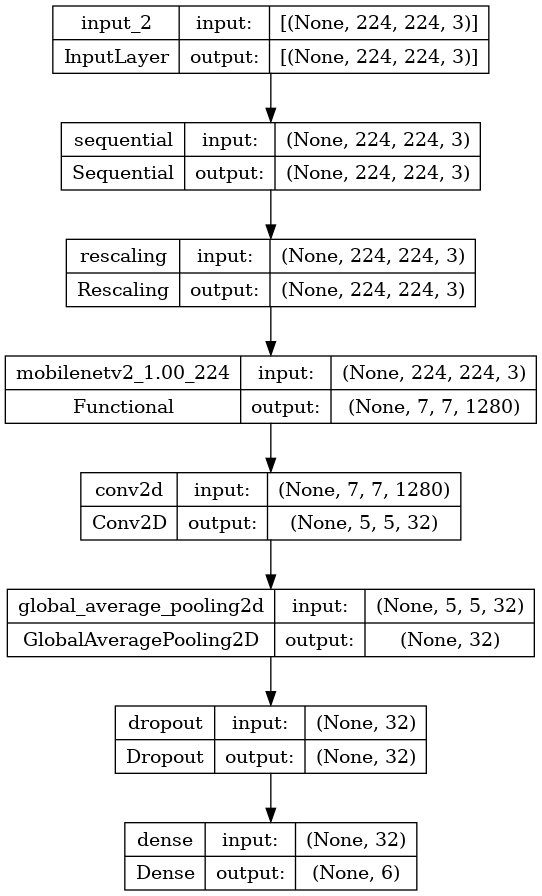

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Compile Model

In [11]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                      

# Train Model

In [12]:
epochs = 20

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    # callbacks=callbacks,
)

model.summary()

Epoch 1/20
65/65 [==============================] - 22s 139ms/step - loss: 1.3657 - accuracy: 0.4801 - val_loss: 0.8167 - val_accuracy: 0.6926
Epoch 2/20
65/65 [==============================] - 3s 51ms/step - loss: 0.9175 - accuracy: 0.6558 - val_loss: 0.6637 - val_accuracy: 0.7549
Epoch 3/20
65/65 [==============================] - 3s 51ms/step - loss: 0.7716 - accuracy: 0.7063 - val_loss: 0.6644 - val_accuracy: 0.7626
Epoch 4/20
65/65 [==============================] - 3s 51ms/step - loss: 0.6944 - accuracy: 0.7257 - val_loss: 0.6039 - val_accuracy: 0.8016
Epoch 5/20
65/65 [==============================] - 3s 51ms/step - loss: 0.6529 - accuracy: 0.7466 - val_loss: 0.5636 - val_accuracy: 0.8288
Epoch 6/20
65/65 [==============================] - 3s 53ms/step - loss: 0.6024 - accuracy: 0.7714 - val_loss: 0.5847 - val_accuracy: 0.7977
Epoch 7/20
65/65 [==============================] - 3s 51ms/step - loss: 0.5438 - accuracy: 0.7845 - val_loss: 0.5302 - val_accuracy: 0.8191
Epoch 8/20


# Save Model

In [13]:
model.save('./model.h5')

# Visualising Training Results

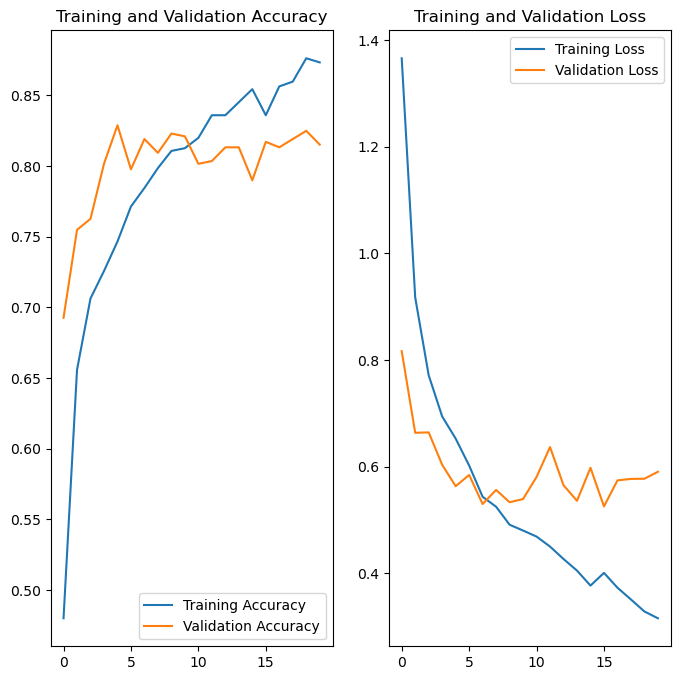

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Inference

In [15]:
import os

def preprocess_img(file):
    img = tf.keras.utils.load_img(
        file,
        target_size=image_size
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    return img_array

inference_folder = '/kaggle/input/trashnet-test/test/'
# image_files = [os.path.join(inference_folder, f) for f in os.listdir(inference_folder) if os.path.isfile(os.path.join(inference_folder, f))]
image_files = [os.path.join(inference_folder, fname) for fname in os.listdir(inference_folder)]

for image_file in image_files:
    # Preprocess the image
    image = preprocess_img(image_file)
    
    # Perform inference
    predictions = model.predict(image)
    
    # Get the predicted class and confidence score
    predicted_class_index = tf.argmax(predictions[0])
#     class_names = train_ds.class_names
    predicted_class = class_names[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index]
    
    # Print the result
    print("Image:", os.path.basename(image_file))
    print("Predicted class:", predicted_class)
    print("Confidence score:", confidence_score)
    print("\n")



1/1 [==============================] - 2s 2s/step
Image: glass9.jpeg
Predicted class: glass
Confidence score: 0.75516045


1/1 [==============================] - 0s 25ms/step
Image: paper10.jpg
Predicted class: paper
Confidence score: 0.7827984


1/1 [==============================] - 0s 24ms/step
Image: metal6.jpg
Predicted class: metal
Confidence score: 0.97779775


1/1 [==============================] - 0s 25ms/step
Image: paper7.jpeg
Predicted class: cardboard
Confidence score: 0.9648372


1/1 [==============================] - 0s 29ms/step
Image: paper1.jpeg
Predicted class: cardboard
Confidence score: 0.9908516


1/1 [==============================] - 0s 24ms/step
Image: glass3.jpeg
Predicted class: trash
Confidence score: 0.74803674


1/1 [==============================] - 0s 25ms/step
Image: cardboard12.jpeg
Predicted class: cardboard
Confidence score: 0.9775334


1/1 [==============================] - 0s 23ms/step
Image: cardboard10.jpeg
Predicted class: cardboard
Confidence s